# Matching

## Описание проекта

**Matching** - это задача поиска и сопоставления двух объектов из разных наборов данных. Такая потребность возникла у маркетплейса, который имеет большой перечен товаров для продажи. На склад стали поступать новые партии товаров, которые имеет небольшие отличия в характеристиках. Технически, это выглядит как совершенно новые товары. Фактически это те же товары, которые уже продаются на маркетплейсе. Задача сопоставить и связать новые товары со старыми, пользуясь совпадающими характеристиками.

**Что надо сделать?**
- разработать алгоритм, который для всех товаров из _validation.csv_ предложит несколько вариантов наиболее похожих товаров из base;
- оценить качество алгоритма по метрике `accuracy@5`.

$$
accuracy@n = \frac{\text{кол-во верных соотношений (из n кандидатов)}} {\text{n (общее кол-во кандидатов)}} * 100\%
$$

Именно в _предложении 5 кандидатов_ для соотношения и заключается отличительная черта данной метрики.

**Данные:** [источник](https://disk.yandex.ru/d/BBEphK0EHSJ5Jw)

- *base.csv* - анонимизированный набор товаров. Каждый товар представлен как уникальный **id** (`0-base, 1-base, 2-base, …`) и вектор признаков размерностью 72.
- *train.csv -* обучающий датасет. Каждая строчка - один товар, для которого известен уникальный **id** (`0-query, 1-query, …`) , вектор признаков И id товара из *base.csv*, который максимально похож на него (по мнению экспертов).
- *validation.csv* - датасет с товарами (уникальный **id** и вектор признаков), для которых надо найти наиболее близкие товары из *base.csv*
- *validation_answer.csv* - правильные ответы к предыдущему файлу.

**План работы:**
- Загрузить данные
- Понять задачу
- Подготовить данные
- Обучить модель (поиск ближайших соседей + ранжирование)
- Измерить качество
- git commit
- Сделать лучше!

Примечание: ячейки кода, исполнение которы занимает продолжительное время, имеют функцию `%%time` и время исполнения, указанное в конце выходных данных. 

___

## Подготовка

В библиотеке [Scikit-Learn](https://scikit-learn.org/stable/modules/neighbors.html#unsupervised-neighbors) существует метод поиска ближайших соседей, но весьма ресурсоёмкий. Так как исходный датасет имеет большой объём можно упростить работу делением всех объектов на кластеры с помощью центроидов. В этом проекте будет использована библиотека [Faiss](https://faiss.ai/index.html).

In [20]:
# импорт библиотек
import phik
import faiss
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# импорт спец. модулей
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, ConfusionMatrixDisplay

# константы
RANDOM_STATE = 42  # фиксация случайности
N_CLUSTERS   = 200 # кол-во кластеров для деления векторного пространства
K_NEIGHBORS  = 100 # кол-во ближайших соседей
N_CELLS      = 5   # конечное кол-во кандидатов на сопоставление
DATA_DIR = 'datasets/'

In [2]:
%%time
# чтение датасетов
base_df       = pd.read_csv(DATA_DIR + 'base.csv')
train_df      = pd.read_csv(DATA_DIR + 'train.csv')
valid_df      = pd.read_csv(DATA_DIR + 'validation.csv')
valid_targets = pd.read_csv(DATA_DIR + 'validation_answer.csv')

CPU times: total: 29 s
Wall time: 32 s


Необходимо привести названия колонок к нижнему регистру и назначить индексацию **id** товаров: `0-base, 1-base, ... или 0-query, 1-query, ...`

In [3]:
# стандартизация названий колонок и смена индексации
for df in [base_df, train_df, valid_df, valid_targets]:
    df.columns = df.columns.str.lower()
    df.set_index('id', inplace=True)

Для упрощения работы в следующей ячейке кода будет описана функция, которая выводит матрицу из графиков распределения значений всех колонок датасета. На вход она принимает один из исходных датасетов, и кол-во строк и столбцов в матрице. Для этих параметров уже заданы значения по-умолчанию, для вывода 72 графиков.

In [8]:
# Функция построения графиков распределения значений в колонках датасета

def show_graph_matrix(dataframe, color='blue', x=6, y=12):
    fig, axs = plt.subplots(y, x, figsize=(x*4, y*4))
    jx = 0 # накопитель
    for i in range(y):
        for j in range(x):
            column = str(i + j + jx)
            data = dataframe[column].value_counts().to_frame().reset_index().sort_values(by=column)
            axs[i, j].plot(column, 'count', data=data, marker='.', linestyle='', color=color)
            axs[i, j].set_title('Значения признака №' + column)
        jx += 5
    plt.show()

Для детального анализа конкретных колонок ниже описана функция, которая выводит top-5 популярных значений (и частоту их повторений), а так же графики распределения этих значений в разных масштабах (общий и увеличенный).

In [5]:
# Функция для подробного анализа значений колонки

def value_analysis(dataframe, column:str, ylim_max:float, color='blue'):
    print('Наиболее популярные значения')
    display((dataframe[column].value_counts(normalize=True)
                              .sort_values(ascending=False)*100)
                              .to_frame()
                              .rename(columns={column:'values','proportion':'frequency, %'})
                              .head())

    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    axs[0].plot((dataframe[column].value_counts(normalize=True).sort_index() * 100), marker='.', linestyle='', color=color)
    axs[0].set_title('График распределения значений колонки №' + column + ' (общий вид)')
    axs[0].set_ylabel('Доля объектов от общего количества, %')
    axs[0].set_xlabel('Значения признака №' + column)
    axs[0].grid()

    axs[1].plot((dataframe[column].value_counts(normalize=True).sort_index() * 100), marker='o', linestyle='', color=color)
    axs[1].set_title('График распределения значений колонки №' + column + ' (увеличенный вид)')
    axs[1].set_ylabel('Доля объектов от общего количества, %)')
    axs[1].set_xlabel('Значения признака №' + column)
    axs[1].set_ylim(0, ylim_max)
    axs[1].grid()
    plt.show()

Для удобного сравнения данны и их распределений из всех датасетов, ниже описана функция выводящая матрицу из графиков по аналогии с функцией `show_graph_matrix`

In [6]:
# Функция построения графиков распределения значений всех датасетов

def show_general_matrix(df_1, df_2, df_3, x=6, y=12):
    fig, axs = plt.subplots(y, x, figsize=(x*4, y*4))
    
    jx = 0 # накопитель
    for i in range(y):
        for j in range(x):
            column = str(i + j + jx)

            data_1 = df_1[column].value_counts(normalize=True).sort_index() * 100
            data_2 = df_2[column].value_counts(normalize=True).sort_index() * 100
            data_3 = df_3[column].value_counts(normalize=True).sort_index() * 100
            
            axs[i, j].plot(data_1, marker='o', linestyle='', color='lightblue')
            axs[i, j].plot(data_2, marker='+', linestyle='', color='red')
            axs[i, j].plot(data_3, marker='x', linestyle='', color='lightgreen')
            axs[i, j].set_title('Значения признака №' + column)
        jx += 5
    plt.show()

___

## Анализ данных

### Base

`Base` - набор из всех товаров (когда либо продававшихся на маркетплейсе) и 72 колонки с их характеристиками. Фактическое значение этих характеристик не имеет значения в рамках этого проекта. Эти данные прошли предварительную обработку (анонимизацию). По этой причине значения выглядят совершенно абстрактными на первый взгляд.

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   0       2918139 non-null  float64
 1   1       2918139 non-null  float64
 2   2       2918139 non-null  float64
 3   3       2918139 non-null  float64
 4   4       2918139 non-null  float64
 5   5       2918139 non-null  float64
 6   6       2918139 non-null  float64
 7   7       2918139 non-null  float64
 8   8       2918139 non-null  float64
 9   9       2918139 non-null  float64
 10  10      2918139 non-null  float64
 11  11      2918139 non-null  float64
 12  12      2918139 non-null  float64
 13  13      2918139 non-null  float64
 14  14      2918139 non-null  float64
 15  15      2918139 non-null  float64
 16  16      2918139 non-null  float64
 17  17      2918139 non-null  float64
 18  18      2918139 non-null  float64
 19  19      2918139 non-null  float64
 20  20      2918139 non

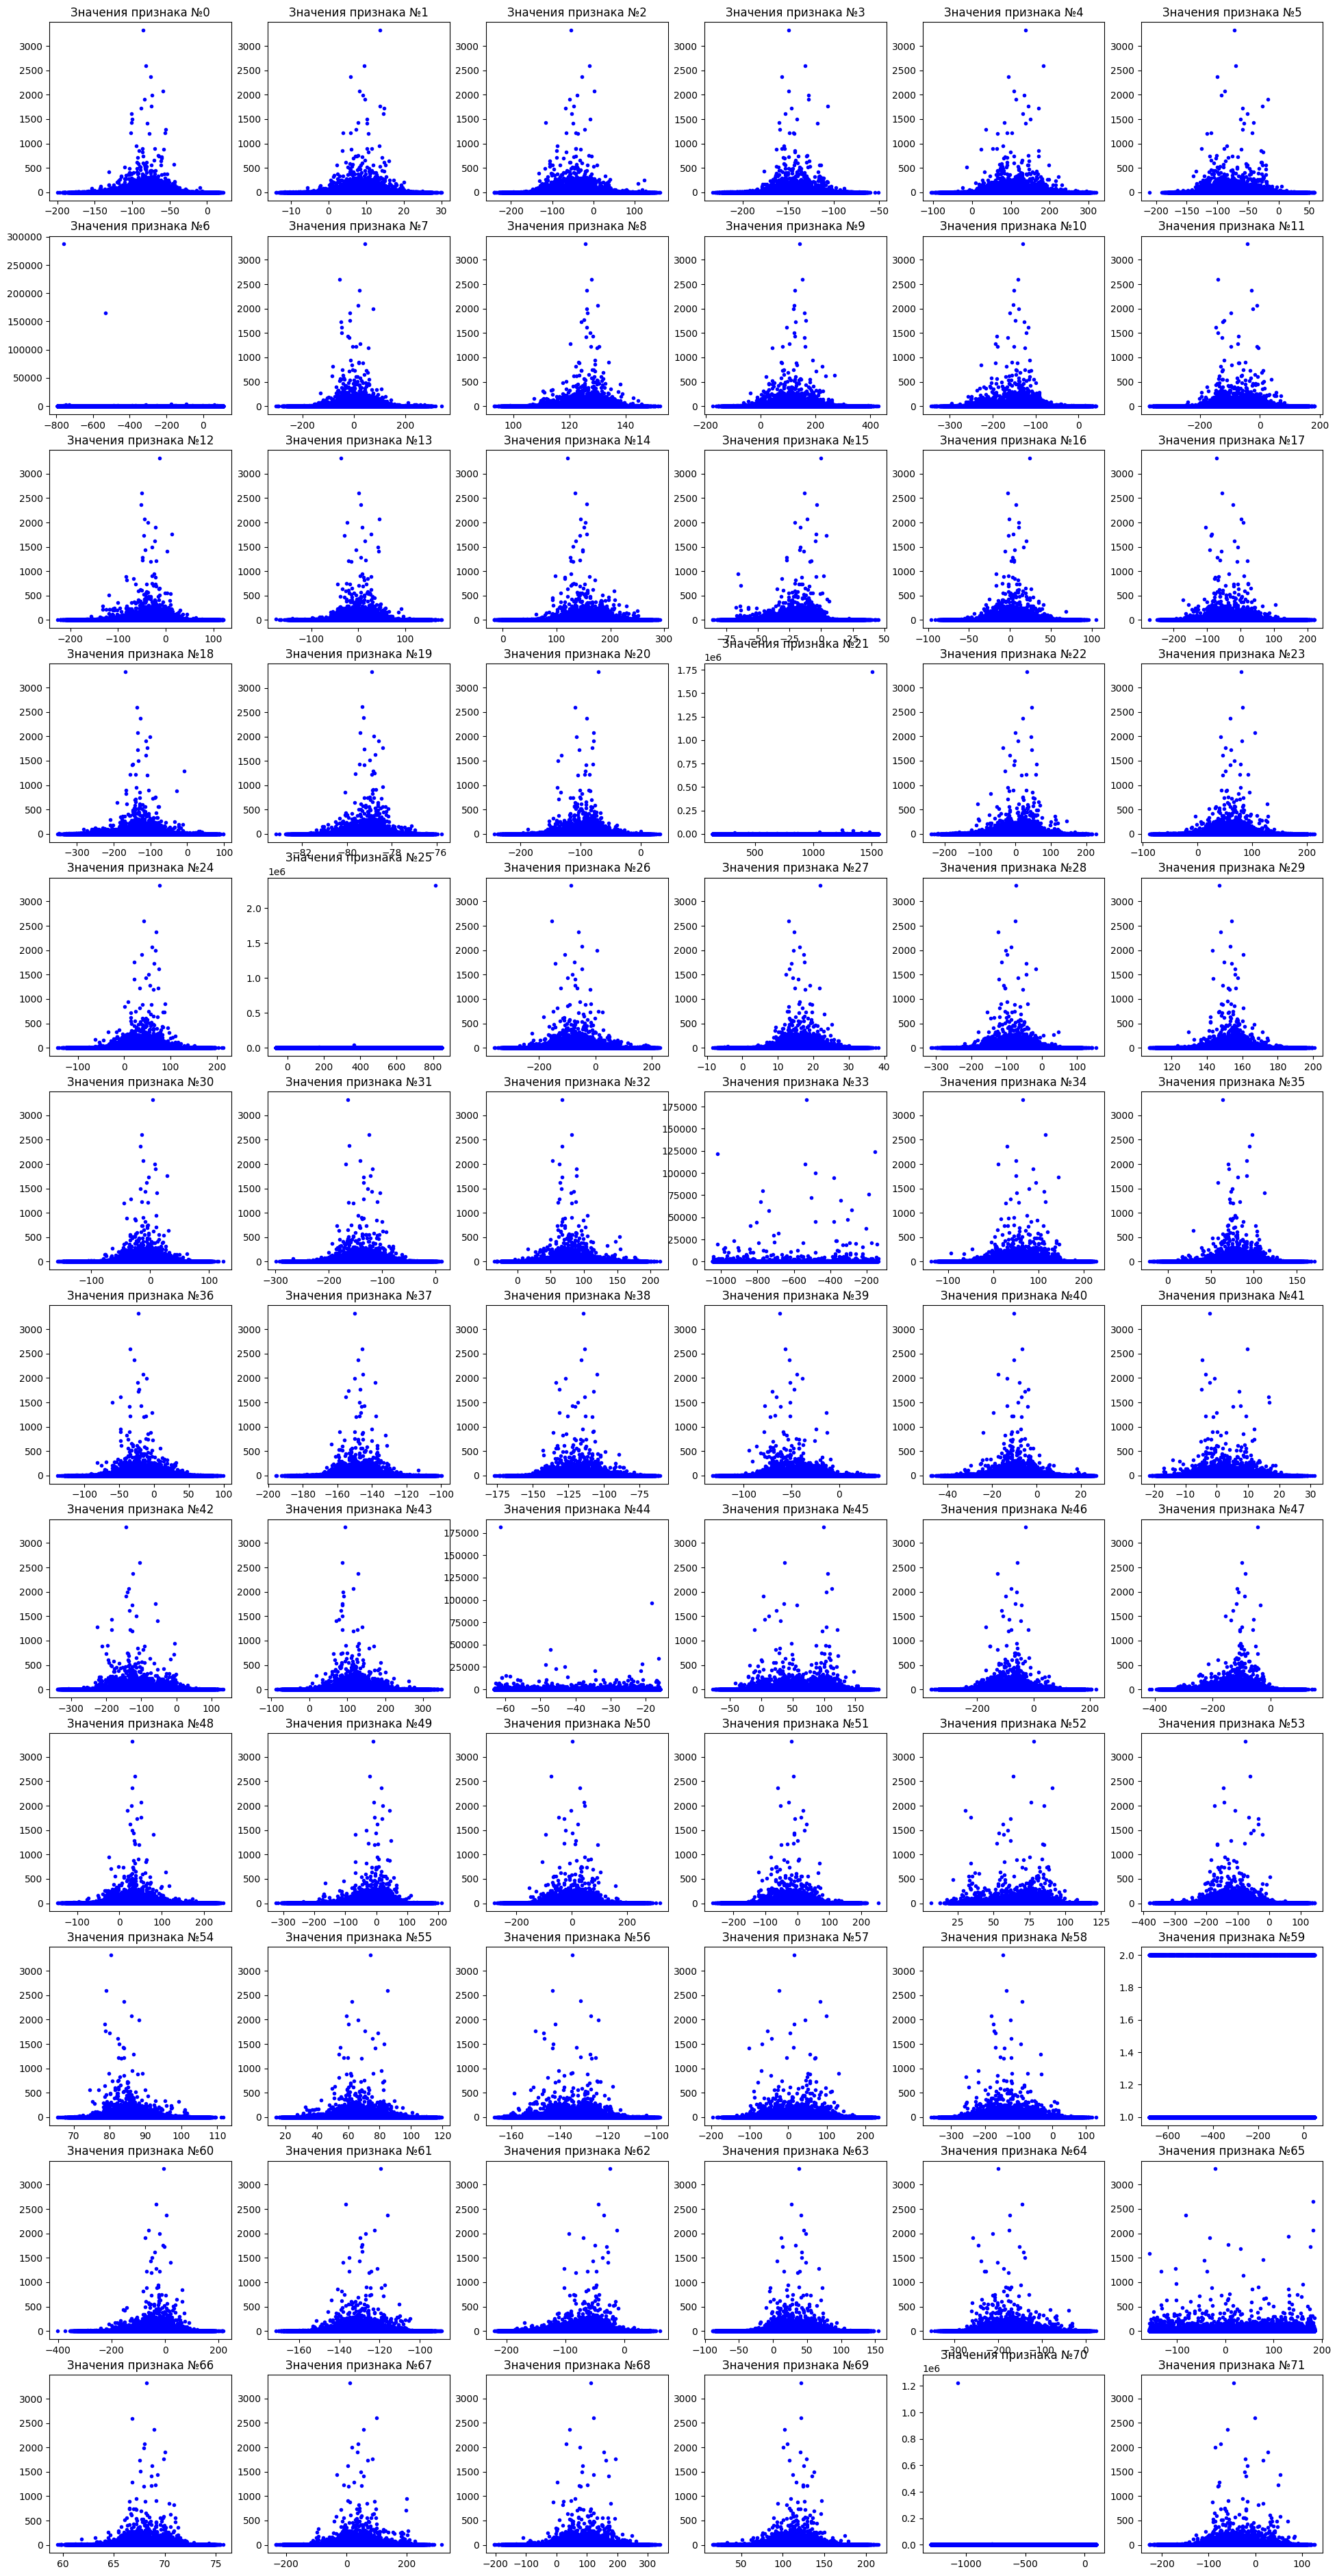

CPU times: total: 5min 26s
Wall time: 5min 33s


In [9]:
%%time
display(base_df.head())
print(base_df.info(verbose=True, show_counts=True))
print('Кол-во товаров-дубликатов:', base_df.duplicated().sum())
show_graph_matrix(base_df)

Большинство данных имеют вид _нормального распределения_ или очень схожего. В каждой колонке свой диапазон значений (широкий/узкий), встречаются как положительные та и отрицательные значения. Отдельное внимание стоит уделить столбцам №№ `6, 21, 25, 44, 45, 59, 65, 70`.

Наиболее популярные значения


,"frequency, %"
6,
-759.626065,9.838119
-530.124724,5.647949
-175.047853,0.127033
-92.055125,0.124120
-750.151074,0.091120


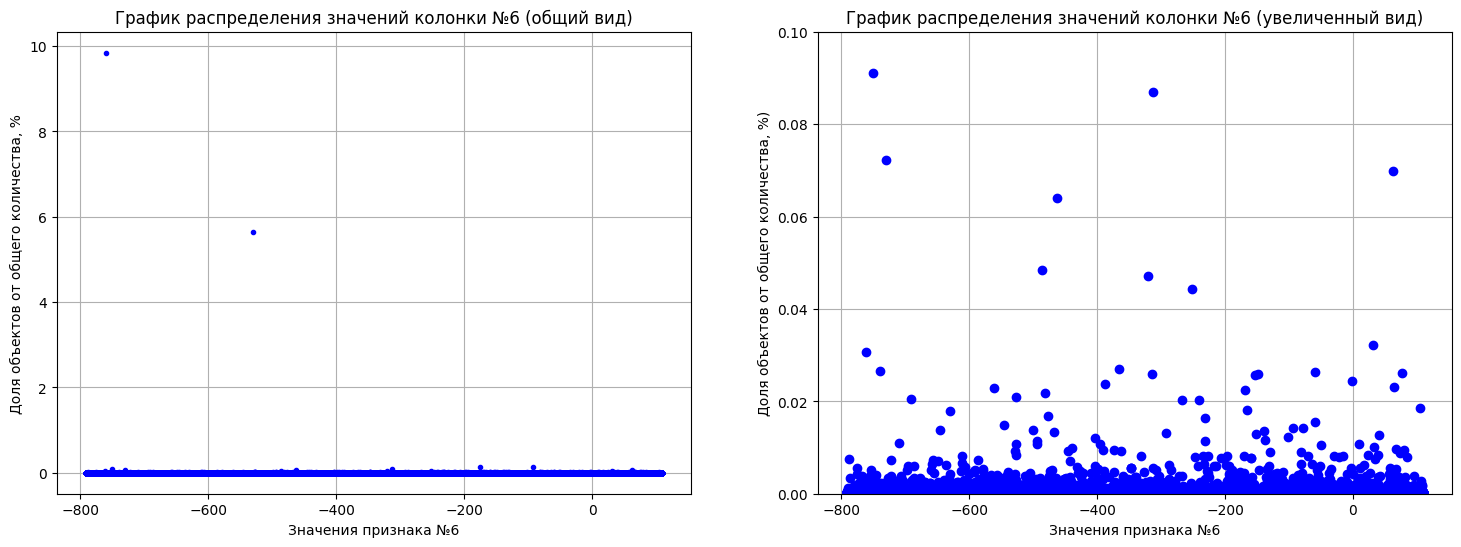

In [ ]:
# распределение значений колонки №6
value_analysis(base_df, '6', 0.1)

Пара значений (-759.626065, -530.124724) особо выделяются. Они встречаются почти у 10% и 5% товаров, соответственно. Остальные значения не выделяются особой популярностью, и распределены равномерно на протяжении всего диапазона.

Наиболее популярные значения


,"frequency, %"
21,
1507.231274,59.214486
1248.126198,1.397603
1342.641120,1.128562
1483.714136,0.804828
1054.205600,0.683689


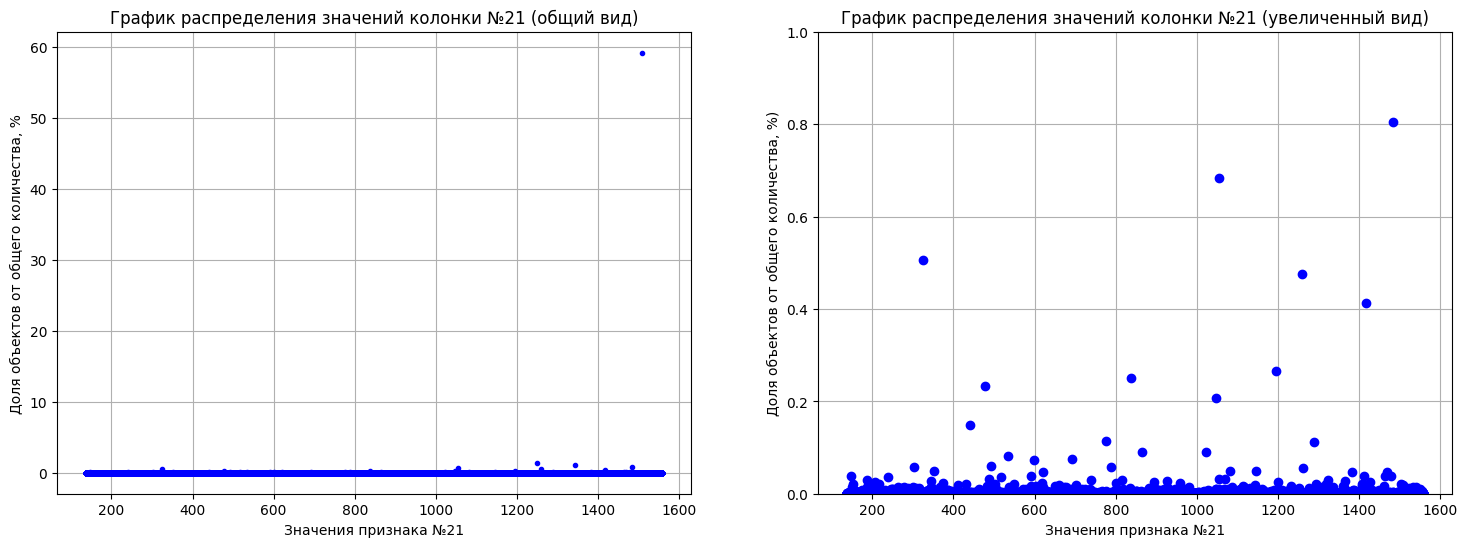

In [ ]:
# распределение значений колонки №21
value_analysis(base_df, '21', 1)

Значений 1507.231274 особо популярно, встречается у ~60%. Остальные значения не популярны. Это отчётливо видно на графиках. В том числе их равномерное распределение на протяжении всего диапазона.

Наиболее популярные значения


,"frequency, %"
25,
813.770071,79.626776
366.779583,1.480670
175.595709,0.225658
514.955051,0.045543
701.226241,0.042150


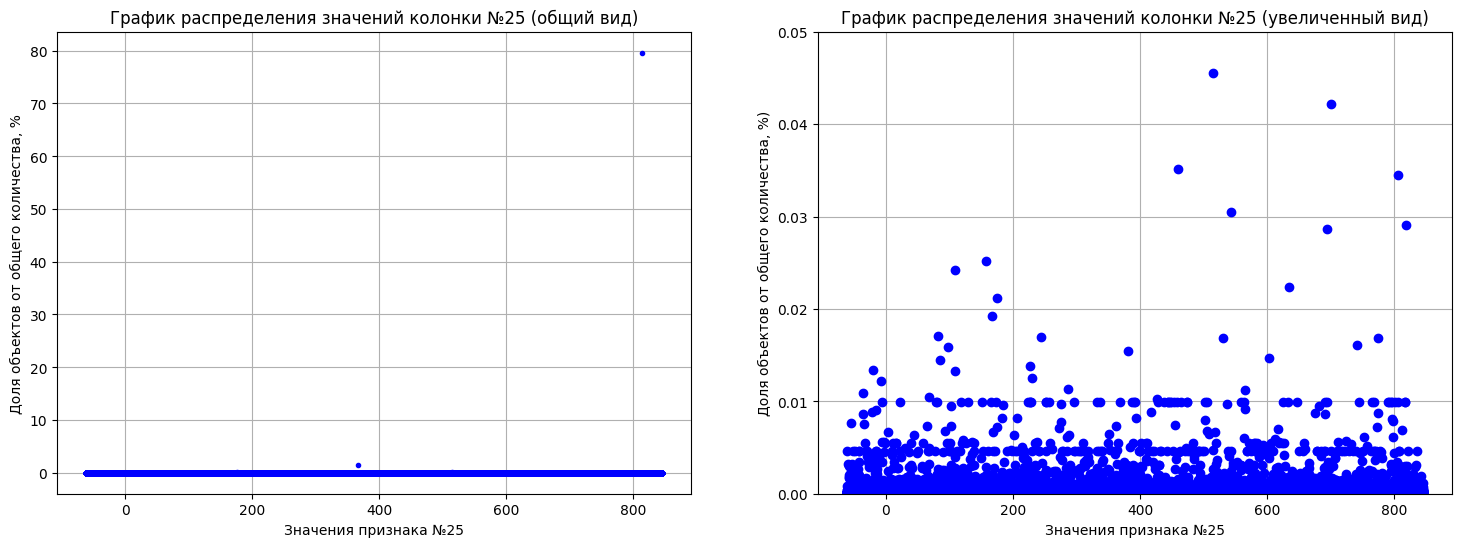

In [ ]:
# распределение значений колонки №25
value_analysis(base_df, '25', 0.05)

Пара значений (813.770071, 813.770071) особо выделяются. Они встречаются почти у 80% и 1,5% товаров, соответственно. Остальные значения не выделяются особой популярностью, и распределены равномерно на протяжении всего диапазона. На увеличенном графике (справа) прослеживается явная закономерность. Некоторые значения встречаются с равной частотой. Возможно, это закодированный цвет товара.

Наиболее популярные значения


,"frequency, %"
44,
-61.441417,6.209197
-18.251750,3.321226
-47.166102,1.526212
-16.440254,1.192849
-21.092403,0.965958


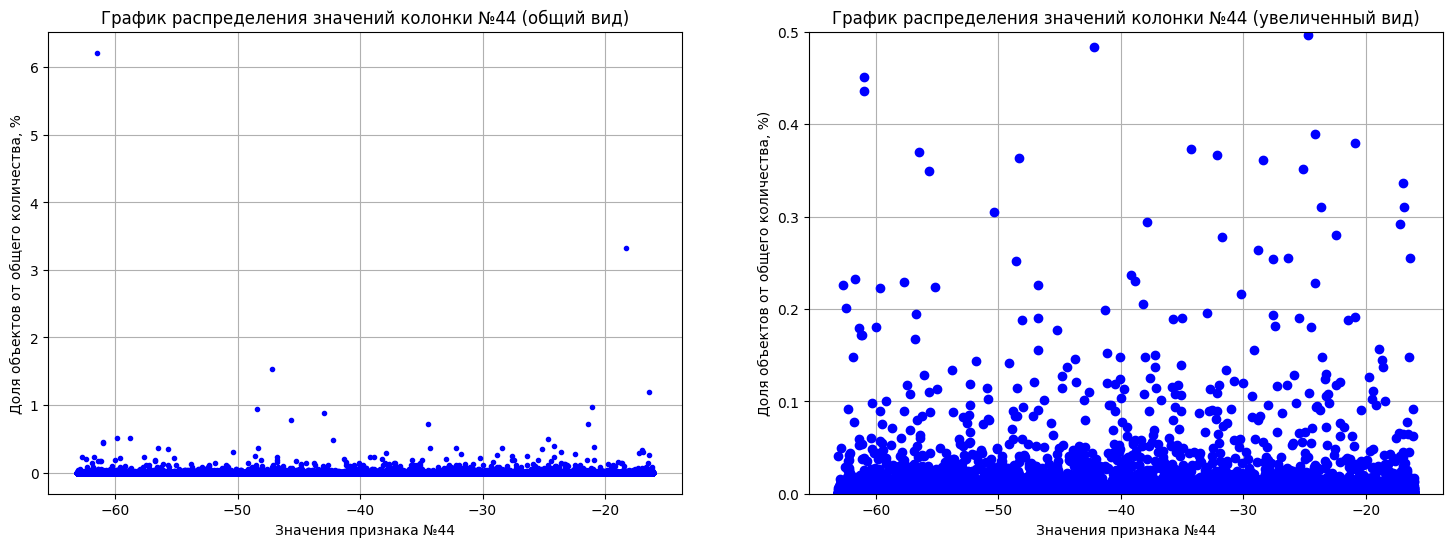

In [ ]:
# распределение значений колонки №44
value_analysis(base_df, '44', 0.5)

Аналогичная ситуация. Пара популярных значений, а все остальные равномерно распределены по всему диапазону.

Значения встречающиеся в колонке №56: [   5.14971423 -251.95235755 -529.39695637 ... -509.1430963  -268.43850644
 -409.24383652] 

Соотношение товаров и уникальность значений их параметра №59
       кол-во товаров
count                
1             2913989
2                2075
Наиболее популярные значения


,"frequency, %"
59,
-230.403784,0.000069
-13.211805,0.000069
-82.038490,0.000069
-188.534014,0.000069
-651.846315,0.000069


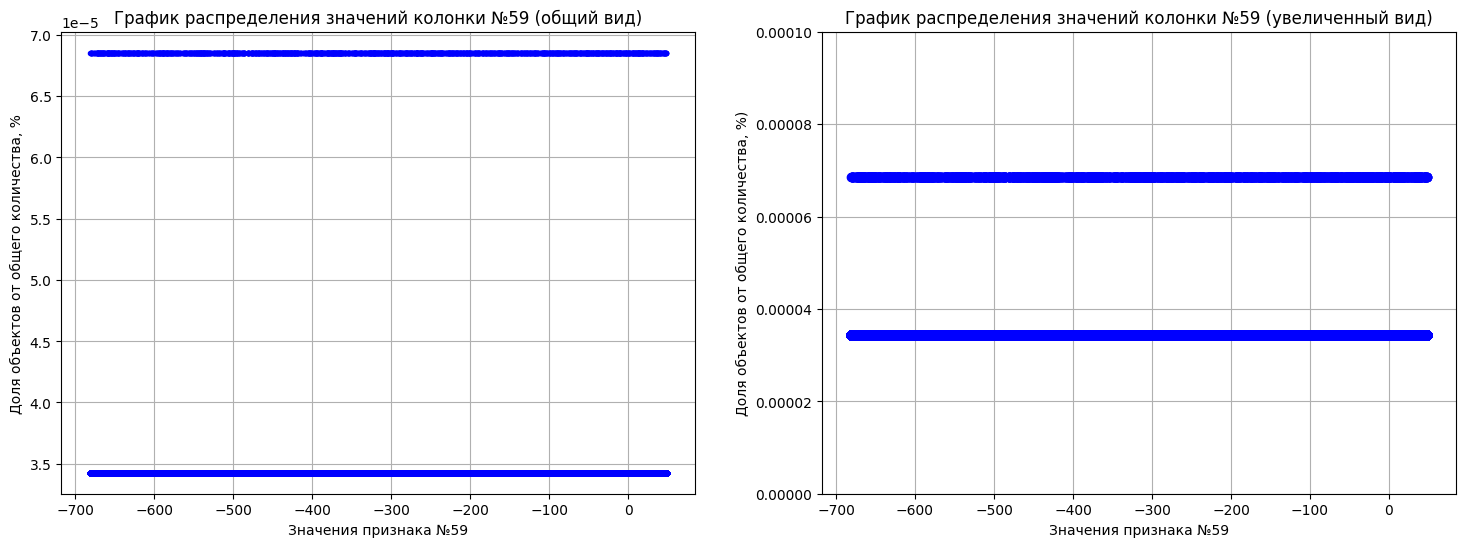

In [ ]:
# анализ колонки №59
print('Значения встречающиеся в колонке №56:', base_df['59'].unique(), '\n')

print('Соотношение товаров и уникальность значений их параметра №59')
print(base_df['59'].value_counts().sort_values(ascending=False).value_counts().to_frame().rename(columns={'count':'кол-во товаров'}))

value_analysis(base_df, '59', 0.0001)

Почти у каждого товара этот параметр уникальный и не повторяется. В от 2075 товаров, которые заимствуют этот параметр от другого товара.

Наиболее популярные значения


,"frequency, %"
65,
-21.533007,0.113703
181.959582,0.091085
-81.475771,0.081113
182.446349,0.070696
130.450168,0.066207


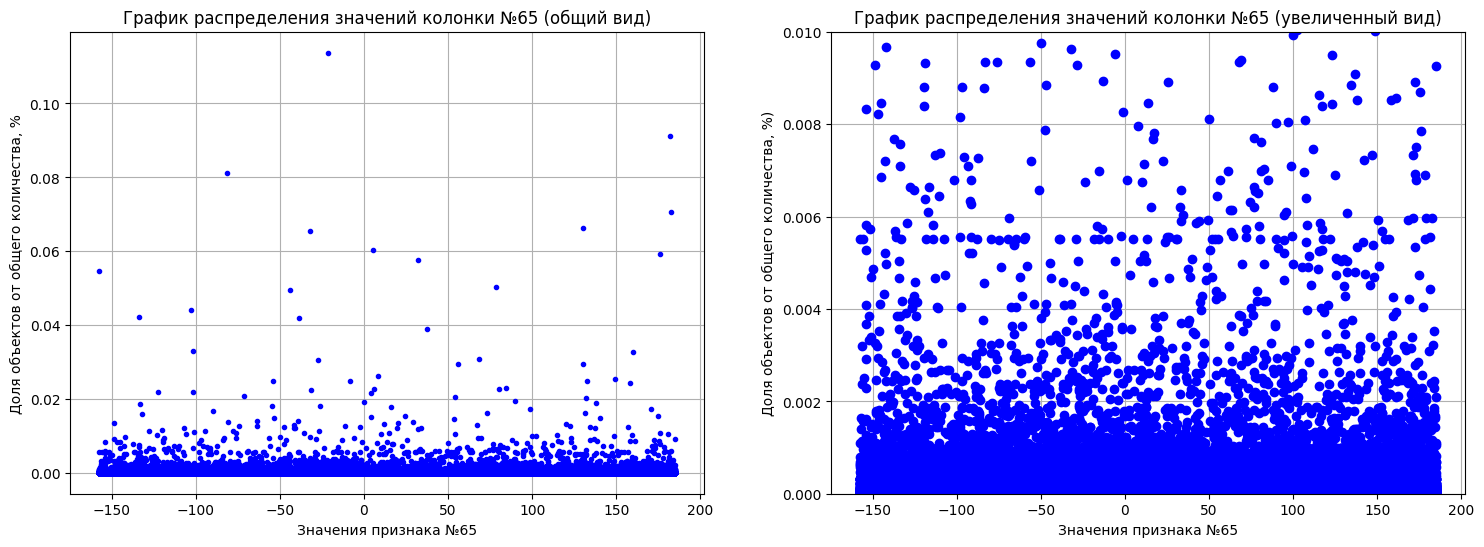

In [ ]:
# распределение значений колонки №65
value_analysis(base_df, '65', 0.01)

Равномерное распределение значений, за редкими исключениями определённых значений.

Наиболее популярные значения


,"frequency, %"
70,
-1074.464888,41.923877
-782.676180,0.235321
-597.491204,0.028957
-799.363667,0.005106
-891.219087,0.005072


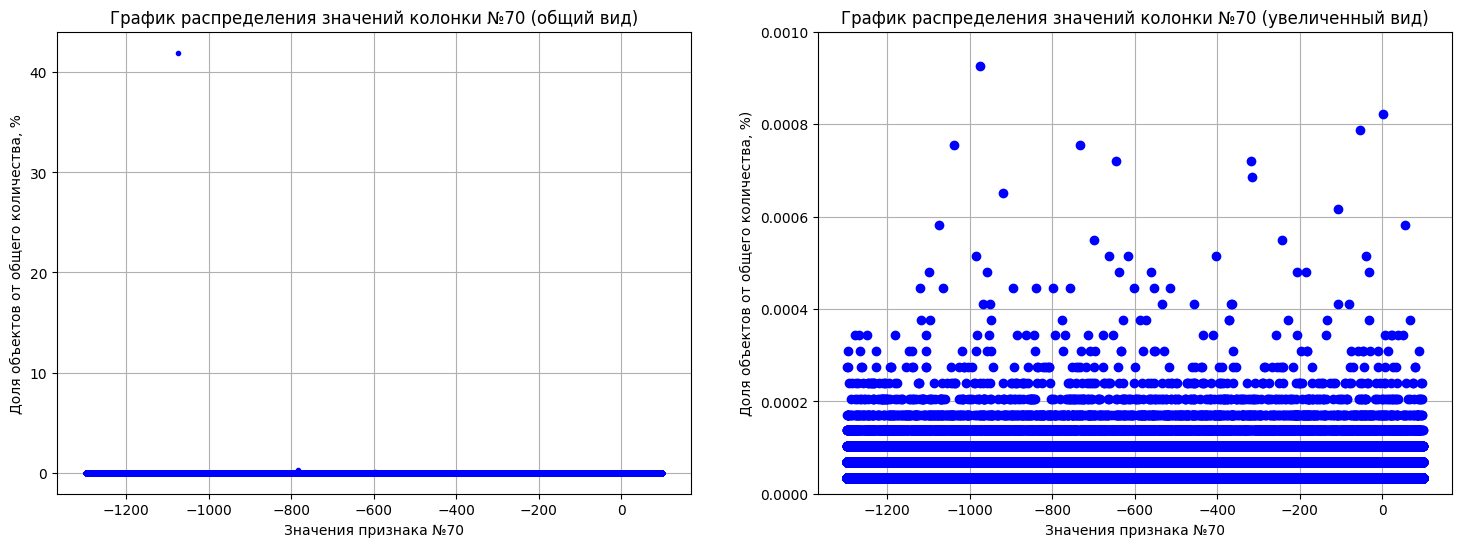

In [ ]:
# распределение значений колонки №70
value_analysis(base_df, '70', 0.001)

Особо популярное значение (-1074.464888) встречающее более чем у 40% товаров. Остальные значения распределены равномерно на протяжении всего диапазона. На увеличенном графике (справа) прослеживается явная дискретность частоты повторения значений.

Общий вывод по данным: значения распределены равномерно. Выбросы отсутствуют.

### Train

`Train` - набор из товаров новых поставок, для которых известны соответствующие товары из "старого" датасета base. ID этого товара содержится в отдельном датасете target.

In [34]:
%%time
# вывод общей информации
display(train_df.head())
train_df.info()
print('Кол-во товаров-дубликатов:', train_df.duplicated().sum())

# выделение цел. признака из обучающей выборки
train_targets = train_df['target']
train_df.drop('target', axis=1, inplace=True)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,target
id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

Тренировочные данные имеют аналогичный вид как в base.csv. Значения параметров №№ `6, 21, 25, 44, 45, 59, 65, 70` распределены равномерно на всём диапазоне. Встречаются особо популярные значения. Большинство данных имеют вид _нормального распределения_ или очень схожего.

### Valid

`Valid` - набор из товаров новых поставок, для которых НЕ известны соответствующие товары и их необходимо найти.

In [9]:
%%time
# вывод общей информации
display(valid_df.head())
valid_df.info()
print('Кол-во товаров-дубликатов:', valid_df.duplicated().sum())

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21

Для того, чтобы не анализировать каждый столбец по отдельности можно воспользоваться функцией `show_general_matrix`. Она позволяет соотнести данные всех датасетов и сравнить на сколько они похожи.

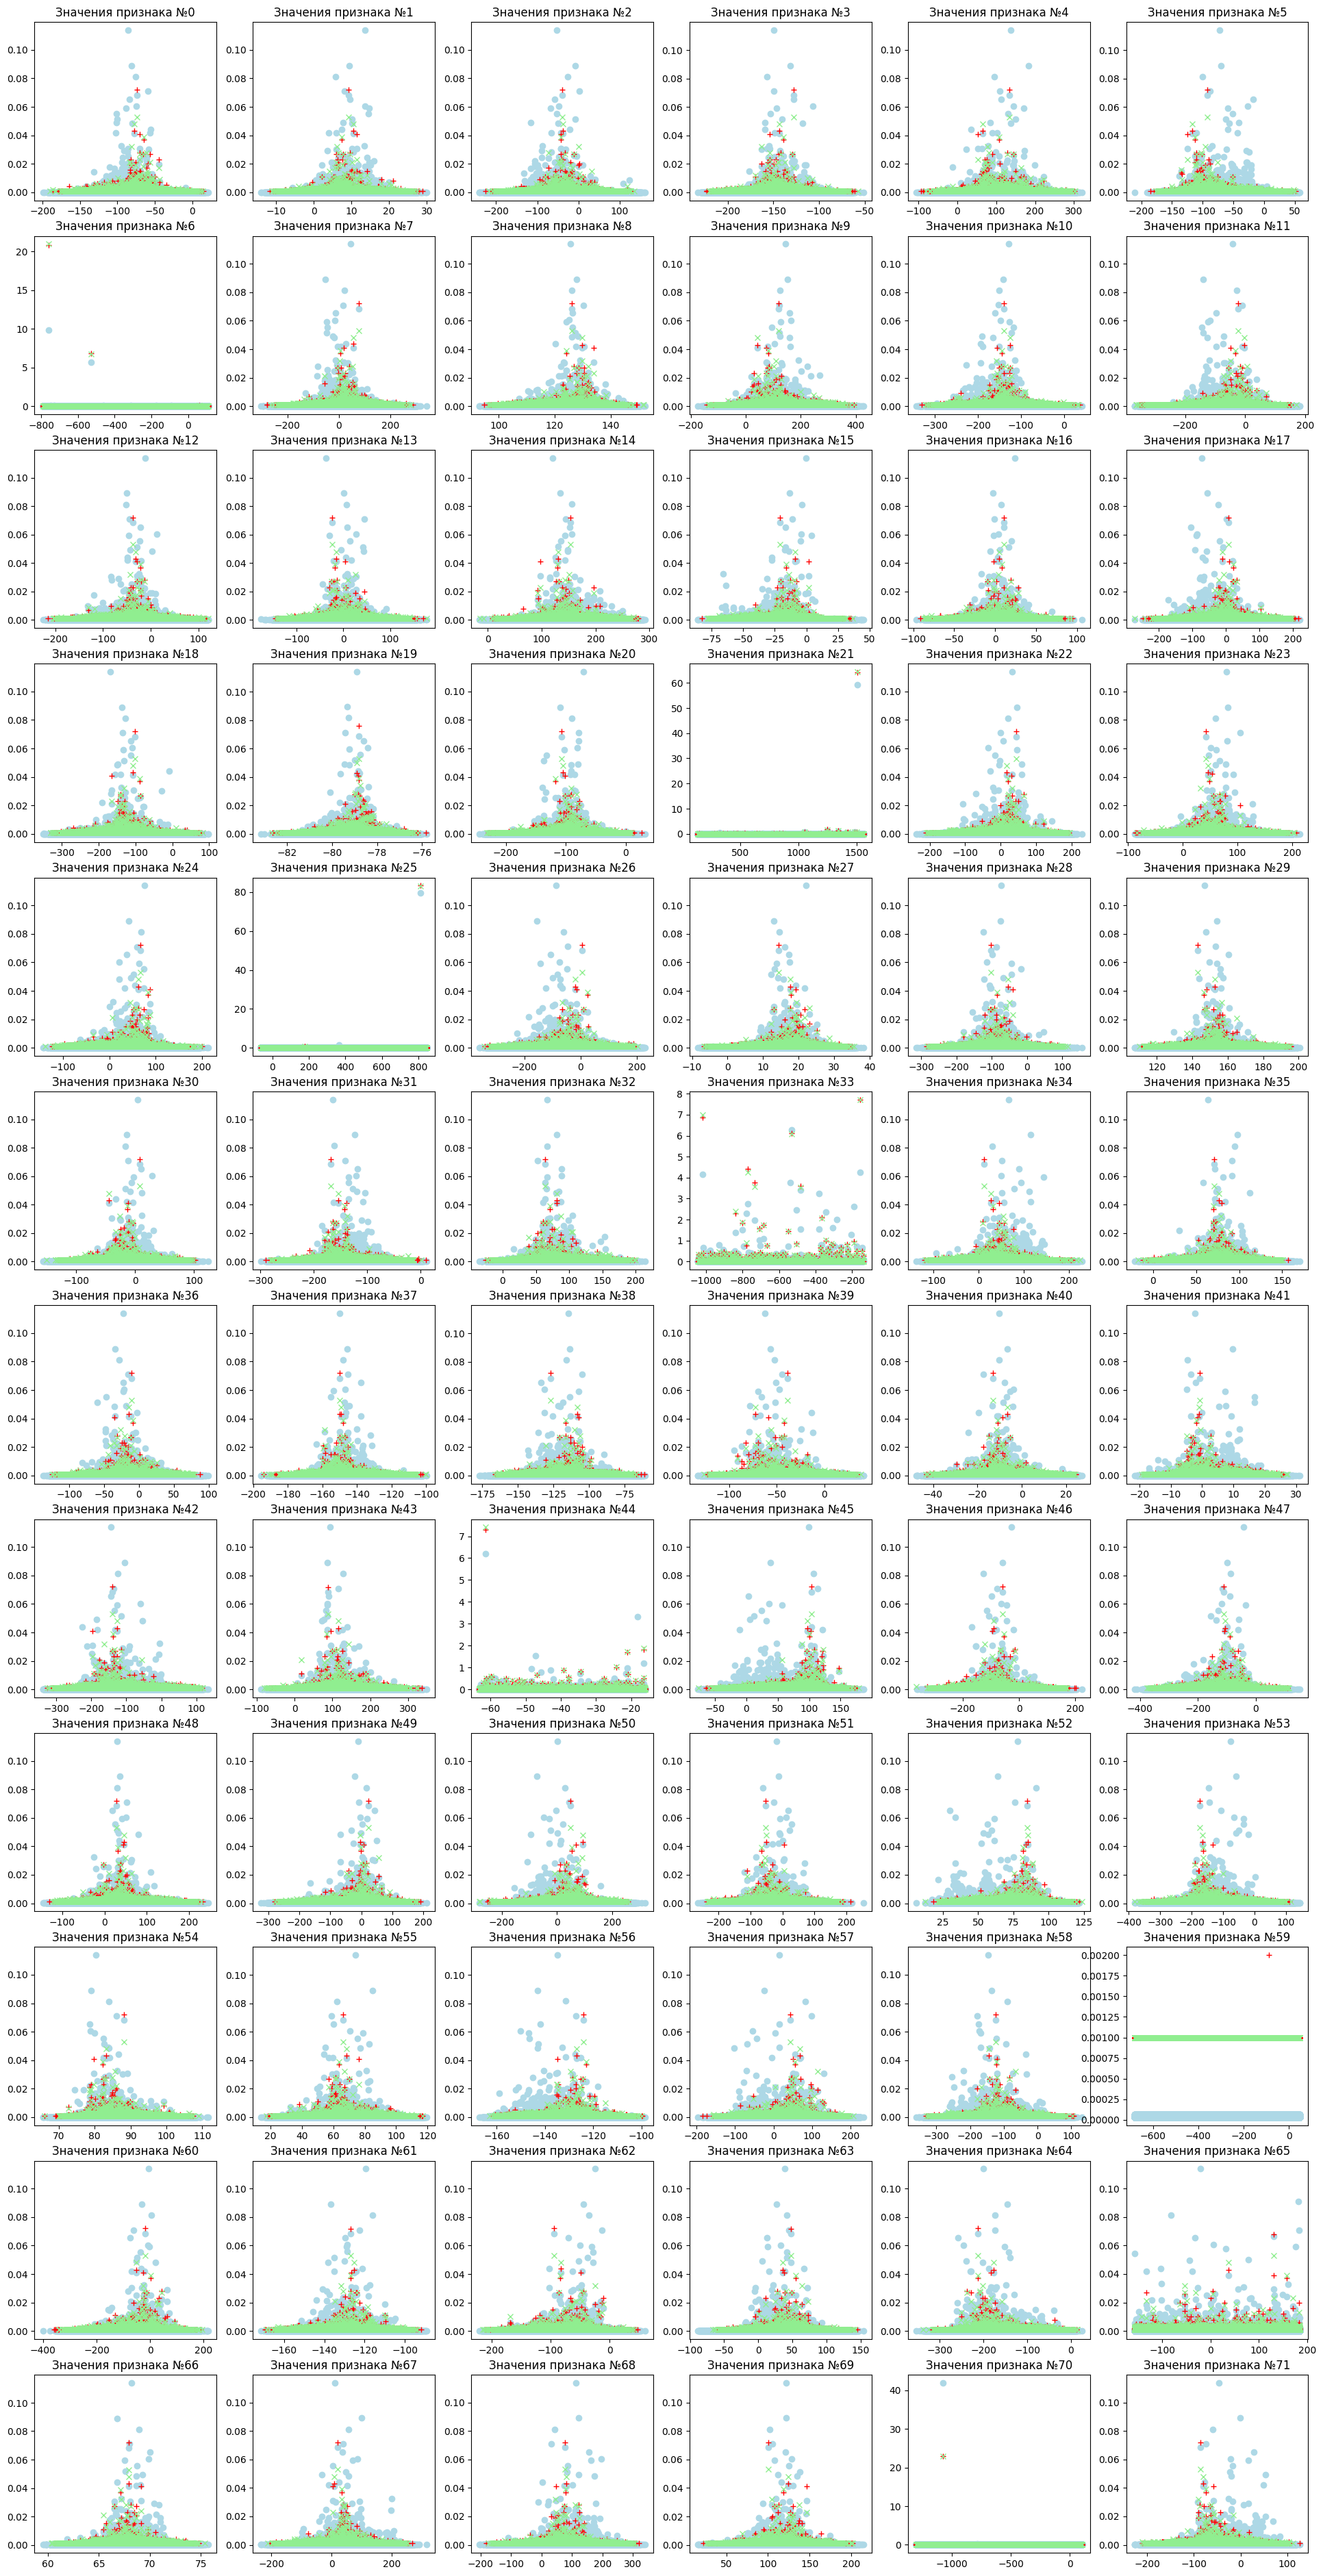

CPU times: total: 6min 37s
Wall time: 6min 44s


In [ ]:
%%time
# вывод общей информации по всем датасетам
display(pd.DataFrame({'Датасет':['base_df', 'train_df', 'valid_df'],
                      'Цвет':['blue', 'red', 'green'],
                      'Символ':['.', '+', 'x']}))
show_general_matrix(base_df, train_df, valid_df)

`Valid_answer` - верные соответствующие товары для выборки Valid. Необходимо для тестирования обученной модели.

In [10]:
display(valid_targets.head())
valid_targets.info()
print('Кол-во товаров-дубликатов:', valid_targets.duplicated().sum())

,expected
id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB
Кол-во товаров-дубликатов: 8498


### Корреляция

Стоит проверить наличие зависимости между признаками, к примеру линейной и квадратичной. За это отвечают коэффициенты корреляции Пирсона и Фи, соответственно.

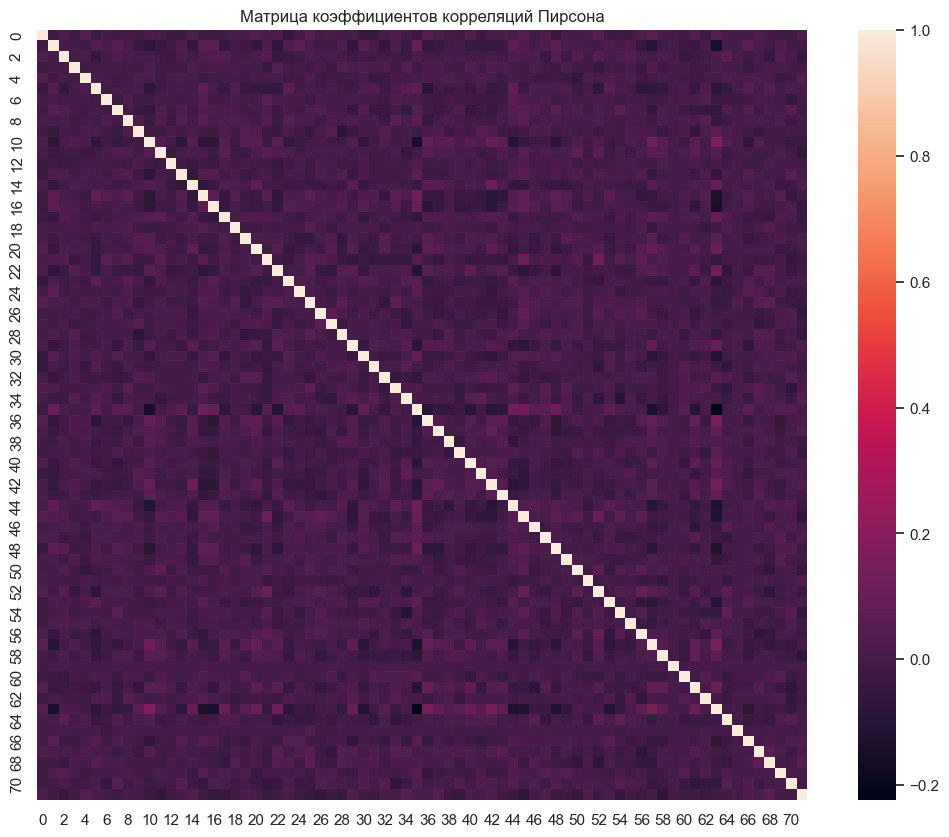

In [30]:
# корреляций Пирсона
sns.set(rc = {'figure.figsize':(13, 10)})
sns.heatmap(base_df.corr(), square=True)
plt.title('Матрица коэффициентов корреляций Пирсона');

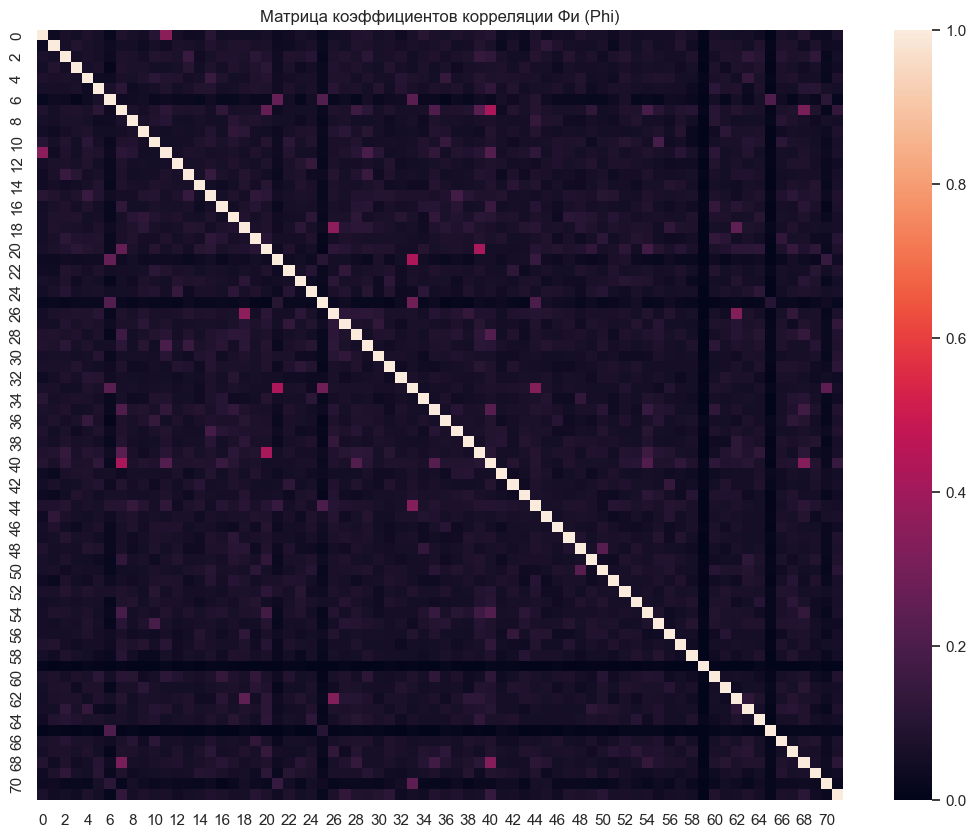

In [29]:
%%time
# корреляции Фи
f, ax = plt.subplots(figsize=(13, 10))
phik_matrix = train_df.phik_matrix(interval_cols=train_df.columns)
sns.heatmap(phik_matrix)
plt.title('Матрица коэффициентов корреляции Фи (Phi)')
plt.show()

**Промежуточный вывод:**

Тип данных - соответствует. Все значения - это числа с плавающий запятов типа `float64`, а id товаров - данные типа `object` или `string`.

Пропуски - отсутствуют.

Выбросы / аномалии - отсутствует. Существует разве что "дисбаланс" между значениями. А именно, некоторые значения встречаются особо часто в сравнении со всеми остальными. К примеру: для признака №25 особо популярен значение 813.770071. Оно встречается у ~80% товаров.

Дубликаты - отсутствуют, за исключением `Valid_answer`. Это может говорить, что одному и тому же "старому" товару, может соответствовать несколько "новых".

Явная зависимость между признаками - отсутствует. Всех их можно считать уникальными характеристиками товара.

Значения признаков сильно отличаются друг от друга. Они могут быть как положительными, так и отрицательными. Могут занимать широкий или узкий числовой диапазон. Для того чтобы каждый признак изначально имел одинаковую значимость необходимо произвести **Масштабирование**.

___

### Масштабирование признаков

In [35]:
scaler = StandardScaler()
scaler.fit(base_df)
base_transform  = scaler.transform(base_df)
train_transform = scaler.transform(train_df)
valid_transform = scaler.transform(valid_df)

# пример
print('Пример масштабированного вектора из "base":\n',  base_transform[0],  '\n')
print('Пример масштабированного вектора из "train":\n', train_transform[0], '\n')
print('Пример масштабированного вектора из "valid":\n', valid_transform[0], '\n')

Пример масштабированного вектора из "base":
 [-1.15921621  0.62035039 -0.51372266  1.39855776  2.26904345 -1.16038496
 -0.28288362  0.37366256 -0.43562659  0.88454365  0.4576469   0.73073908
 -0.41463426  0.78201584  1.00285473 -0.37510107 -0.20510187  0.33189056
  0.99042818 -0.36617164 -0.2019014   0.62431793 -0.49577625 -0.1530666
 -2.01843422  0.42159108  0.40135749 -1.69555507 -0.89876331 -0.29430765
  0.05313913  0.03532411 -0.26462494  0.06513401 -0.83885471  1.69344411
  0.80234648 -0.67295311 -0.38906162  0.1131067  -0.40123943 -1.40868981
 -0.70640697 -0.96219636 -1.19775652 -1.29778618 -0.22126234  0.00696112
  0.9529048  -2.37308311 -1.29941832  1.57543507  0.84989106  0.52136797
  0.28986782  0.88773797  0.43402009 -1.13324375  0.70881925  1.52490547
  0.00679186 -0.84751261  1.18904887  0.19052392  0.07358854 -0.89478931
 -2.26249347 -0.51043767  0.29300367 -0.0140507   1.78141979 -0.31232868] 

Пример масштабированного вектора из "train":
 [ 1.29951853  1.99688841  0.063

Данные готовы для обработки.

___

##  Поиск ближайших соседей

Принцип работы [Faiss](https://faiss.ai/index.html):
1. Отображение всех объектов (векторов) в едином пространстве
2. Деление полученного пространства на отдельные части (кластеры) при помощи спец. алгоритма библиотеки
3. Для каждого кластера происходит поиск его центра (центроида)
4. Таким образом, для нового вектора можно быстрой найти ближайших соседей, вычислив расстояние именно до центроидов (не перемножая новый вектор со всеми остальными векторами).
5. После выявления ближайшего кластера, новый вектор перемножается векторами только из этого кластера.

На этом этапе данные будут преобразованы из датафрейма в двумерный массив и в результате этого потеряют свои уникальные **id**. Заблаговременно необходимо создать словарь для сопоставления **порядкового номера** вектора (`161948`) и **id** товара (`'161948-base'`).

In [31]:
# словарь id и номеров векторов
base_index = {k: v for k, v in enumerate(base_df.index.to_list())}

print('Пример содержания словаря:\n', list(base_index.items())[0:3])

Пример содержания словаря:
 [(0, '0-base'), (1, '1-base'), (2, '2-base')]


`FlatL2` - мера близости вектором L2-норма (евклидово расстояние). По этой причине большое значение имеет "нормализованы ли признаки?", поскольку в этой ситуации признак бóльшей величины будет играть бóльшую роль в предсказании. Но это не отображает достоверность его значимость.

`quantizer` - квантизатор, который получает на вход вектора размерностью `dimensions` и рассчитывает расстояние между ними по евклидовой норме.

`idx_l2` - пространство векторов размерностью `dimensions`, разделяемое на фиксированное кол-во кластеров из `N_CLUSTERS` с помощью `quantizer`.

In [36]:
dimensions = base_transform.shape[1] # n-мерность векторов

quantizer = faiss.IndexFlatL2(dimensions)
idx_l2 = faiss.IndexIVFFlat(quantizer, dimensions, N_CLUSTERS)

Функция `np.ascontiguousarray()` располагает последовательно весь массив данных в оперативной памяти.

In [37]:
# обучение делителя пространства на первых 50 тысячах объектов из df_base
idx_l2.train(np.ascontiguousarray(base_transform[:50000, :]).astype('float32'))

# деление всех векторов по правилам, сформированным на предыдущем шаге 
idx_l2.add(np.ascontiguousarray(base_transform).astype('float32'))

Далее следует **процесс поиска** соседей. Дословно строчка кода звучит так: для каждого вектора из `trans_train` найди по **N** ближайших векторов из `df_base` (которые уже размечены на отдельные кластеры). Результатом являются:
- `idx` - порядковые номера ближайших векторов, и
- `distance` - расстояние между векторами.

Этот процесс может быть долгим. Ориентировочное время поиска: 5 минут (для CPU). Время вычисления сильно зависит от кол-ва кластеров.

In [38]:
%%time

distance, train_idx = idx_l2.search(np.ascontiguousarray(train_transform).astype('float32'), K_NEIGHBORS)

print('Примеры train_idx :\n', train_idx[:3], '\n')
print('Примеры vectors :\n', distance[:3])
del distance

Примеры train_idx :
 [[ 598613  755584  336969 1934845   13374 1136231  480296  583287 2360257
   450667  988777 1653095 1818641  503716 1631947   89840  143978  986050
   629775 2346335  223859  352715  455829 1747988 1674977  443428 2295048
   728097 1113711 1746258  751217  854264  792610 1375244  199196 2212973
  2398299 1679537  679629  684958]
 [ 737853   15185  519311  223456  464427 2524968  301385  838522  124343
  2162616 1325497  295462 1054077 2296593 1946148  224544  412497 2469267
  2584784    2133 2175159 1252594  413070  745562 1445783  838183  690454
  1125764  809896 2046499   34831 2014945   51220 1886873  311357 1405553
  1412188  217284 2733705 2876234]
 [ 173120 1784963 2863071 1143288  955831  137853 1368891  774247 1984148
  1479188 1238526 2351134  641280 1532675 1774212  948608   12304 2395210
  1905367 1341266 2642468 2475151  859626  182696 1392119 1359128 2710601
  1495133 1659033  276279  792349 1107257  366439 2426036 1240284  606185
  1844229  529805 213

NameError: name 'vectors' is not defined

`targets` - список `id` товаров, подходящих по мнению экспертов. (одномерный массив)

`idx` - наборы из k ближайших соседей. Для получения `id` товара, нужно указать числовой индекс в словаре `base_index`. 

In [39]:
# функция вычисления accuracy@n
def accuracy_n(targets, predict, base_index=base_index):
    acc = 0
    for target, candidates in zip(targets.tolist(), predict.tolist()):
        acc += int(target in [base_index[number] for number in candidates])

    return (acc / len(predict) * 100)

In [40]:
print('accuracy@{}: {:.2f}%'.format(K_NEIGHBORS, accuracy_n(train_targets, train_idx)))

accuracy@40: 63.55%


**Промежуточный вывод:**

На этом этапе создано и наполнено векторное пространство из объектов датасета `base`. Пространство поделено на 200 кластеров, что ускоряет и уточняет процесс поиска. Для каждого объекта из `train` были найдены 20 ближайших векторов при помощи меры `FlatL2`. Упомянутые числовые параметры были подобраны эмпирическим путём, но отмечу, что опыты с трёхзначными числами не проводились.

Текущий результат можно трактовать следующим образом: Для 63.43% новых товара из датасета `train` найдено 100 кандидатов для сопоставления, среди которах есть целевой (т.е. выбранный экспертом).

Число кластеров и кол-во ближайших соседей подобраны экспериментальным путём. При этом первый параметр влияет на скорость поиска, а второй - на качество поиска.

Далее, среди найденных кандидатов необходимо выявить самый подходящий. Для этого их требуется отсортировать.

## Ранжирование

### Формирование тренировочной выборки

Первым делом необходимо составить новый датафрейм состоящий из двух половин:
1. Искомые векторы
2. Несколько кандидатов на сопоставление для каждого искомого вектора.

Последним столбцом для этого вектора станет `matching` содержащий правильный ответ: 1 - вектор подходит, 0 - вектор не подходим.

In [19]:
# подготовка датафрейма с перечнем ID новых и старых объектов
idx_df = pd.DataFrame(data=train_idx, index=train_df.index)
idx_df = pd.melt(idx_df.T)
idx_df.columns = ['id_query', 'candidate']
idx_df['id_candidate'] = [base_index[number] for number in idx_df['candidate'].values]
idx_df.drop('candidate', axis=1, inplace=True)

display(idx_df)

,id_query,id_candidate
0,0-query,675816-base
1,0-query,877519-base
2,0-query,361564-base
3,0-query,2725256-base
4,0-query,13406-base
...,...,...
3999995,99999-query,2661198-base
3999996,99999-query,882900-base
3999997,99999-query,2828616-base
3999998,99999-query,1365058-base


Полученные колонки с `id` товаров будут использованы для объединения при помощи метода `merge()`. В качестве данных будут использоваться уже отмасштабированные признаки.

In [16]:
# формирование датафреймов из масштабированных данные
base_transform_df  = pd.DataFrame(base_transform,  index=base_df.index)
train_transform_df = pd.DataFrame(train_transform, index=train_df.index)
valid_transform_df = pd.DataFrame(valid_transform, index=valid_df.index)

# объединение base и train по заготовленным id
train_base_df = idx_df.merge(train_transform_df, left_on='id_query', right_on='id', how='left')
train_base_df = train_base_df.merge(base_transform_df, left_on='id_candidate', right_on='id', how='left', suffixes=('', '_base'))
train_base_df = train_base_df.merge(train_targets, left_on='id_query', right_on='id', how='left')
display(train_base_df)

,id_query,id_candidate,0,1,2,3,4,5,6,7,...,63_base,64_base,65_base,66_base,67_base,68_base,69_base,70_base,71_base,target
0,0-query,675816-base,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,...,1.627806,0.072924,0.427460,-0.496641,0.394758,-0.568302,0.066837,0.995267,0.708902,675816-base
1,0-query,877519-base,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,...,1.615281,-0.247046,-0.404396,-1.148503,0.412697,-0.375744,0.728224,0.544932,0.270560,675816-base
2,0-query,361564-base,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,...,1.723392,-0.369458,0.988497,-1.100241,0.280916,-0.492041,0.532096,0.543575,0.090279,675816-base
3,0-query,2725256-base,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,...,2.073714,-0.360444,-0.335696,-1.196697,0.156157,-1.269117,0.007341,1.964740,0.834797,675816-base
4,0-query,13406-base,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,...,1.725501,-0.582972,-0.973235,-0.608757,0.321407,-0.678275,0.164748,2.281264,0.505112,675816-base
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,99999-query,2661198-base,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,1.149390,0.885642,...,-0.429302,0.969324,-0.454186,0.430103,0.782123,1.106812,0.849291,2.215694,-0.562640,2769109-base
3999996,99999-query,882900-base,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,1.149390,0.885642,...,0.326835,0.872012,-1.168815,0.800925,0.059721,-0.835456,-0.343547,1.325727,-1.422351,2769109-base
3999997,99999-query,2828616-base,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,1.149390,0.885642,...,-0.833601,0.008207,-0.344459,0.418317,1.056163,-0.468449,0.786053,-0.713847,-0.422407,2769109-base
3999998,99999-query,1365058-base,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,1.149390,0.885642,...,-0.160225,-0.085830,0.219114,-0.344030,0.350846,1.517193,1.509195,-0.257649,-0.930244,2769109-base


In [17]:
# преобразование целевого признака для бинарной классификации
train_base_df['matching'] = (train_base_df['id_candidate'] == train_base_df['target']).astype('int')
display(train_base_df[['id_query', 'id_candidate', 'target', 'matching']])
train_base_df.drop('target', axis=1, inplace=True)

,id_query,id_candidate,target,matching
0,0-query,675816-base,675816-base,1
1,0-query,877519-base,675816-base,0
2,0-query,361564-base,675816-base,0
3,0-query,2725256-base,675816-base,0
4,0-query,13406-base,675816-base,0
...,...,...,...,...
3999995,99999-query,2661198-base,2769109-base,0
3999996,99999-query,882900-base,2769109-base,0
3999997,99999-query,2828616-base,2769109-base,0
3999998,99999-query,1365058-base,2769109-base,0


In [18]:
# выделение признаков и таргета
y_train = train_base_df['matching']
X_train = train_base_df.drop(['id_query', 'id_candidate', 'matching'] , axis=1)

display(y_train.to_frame())
display(X_train)

,matching
0,1
1,0
2,0
3,0
4,0
...,...
3999995,0
3999996,0
3999997,0
3999998,0


,0,1,2,3,4,5,6,7,8,9,...,62_base,63_base,64_base,65_base,66_base,67_base,68_base,69_base,70_base,71_base
0,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,-2.296794,-1.459626,...,-0.927103,1.627806,0.072924,0.427460,-0.496641,0.394758,-0.568302,0.066837,0.995267,0.708902
1,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,-2.296794,-1.459626,...,-0.676032,1.615281,-0.247046,-0.404396,-1.148503,0.412697,-0.375744,0.728224,0.544932,0.270560
2,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,-2.296794,-1.459626,...,-0.332150,1.723392,-0.369458,0.988497,-1.100241,0.280916,-0.492041,0.532096,0.543575,0.090279
3,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,-2.296794,-1.459626,...,-0.514269,2.073714,-0.360444,-0.335696,-1.196697,0.156157,-1.269117,0.007341,1.964740,0.834797
4,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,-2.296794,-1.459626,...,-0.281062,1.725501,-0.582972,-0.973235,-0.608757,0.321407,-0.678275,0.164748,2.281264,0.505112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,1.149390,0.885642,-0.902251,-0.794043,...,-0.913118,-0.429302,0.969324,-0.454186,0.430103,0.782123,1.106812,0.849291,2.215694,-0.562640
3999996,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,1.149390,0.885642,-0.902251,-0.794043,...,-0.755572,0.326835,0.872012,-1.168815,0.800925,0.059721,-0.835456,-0.343547,1.325727,-1.422351
3999997,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,1.149390,0.885642,-0.902251,-0.794043,...,-0.612894,-0.833601,0.008207,-0.344459,0.418317,1.056163,-0.468449,0.786053,-0.713847,-0.422407
3999998,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,1.149390,0.885642,-0.902251,-0.794043,...,-0.824905,-0.160225,-0.085830,0.219114,-0.344030,0.350846,1.517193,1.509195,-0.257649,-0.930244


В результате получилась выборка для обучения:
* **2 000 000 записей** = 100 000 новых товаров (query) * 20 ближайших кандидатов для каждого.
* **144 признака** = 72 признака "старых" товаров из `base` + 72 признака "новых" товаров из `train`.
* бинарный целевой признак. 

### Формирование валидационной выборки

Аналогичную процедуру необходимо выполнить для валидационной выборки.

In [19]:
%%time
# поиск ближайших соседей для валидационной выборки
vectors, valid_idx = idx_l2.search(np.ascontiguousarray(valid_transform), K_NEIGHBORS)

print('Примеры idx :\n', valid_idx[:3], '\n')
print('accuracy@{}: {:.2f}%'.format(K_NEIGHBORS, accuracy_n(valid_targets['expected'], valid_idx)))
del vectors

Примеры idx :
 [[2192372 2177660  342838  574649 1954150 2363873 1225777 1405698 2910875
  1719453 2512787 2504096 1243148 2571634  536120  995930  462353  814942
  1508869 2536973 2239161  340288  106841  999102  277780 2875559 2886161
  1837653 1952068 1869523 2546410 1037237 2664485 1781035 1660795  270881
  1359889 2508079  925319 1520306]
 [ 157966   11829  847800 1902634 2580959 2275539 2561209 2123768  138680
  2435892  374422 1459534  135315 1584915 1884931 2893838 1872797 1256848
  1187110  489609  154993  706512 1751144 2055627  434145 1931125 1162720
  2242396 2888502  801389 1257658 1778717  881233 1686132 1499186 2172702
  2512114 2769325 1068829 2159389]
 [ 431806  148400  451870  281105   24989  685598  365989  279417  674511
   318265  832464  195078  359945  223916  208180 1706372  586213 2154246
   119568  677348 1628321  769163 1107448  506287 1954448 1901005 2206235
  2535506 2004274 1985724 1791748 2708668 2581495  461160 1597514 1727005
  1124378  707917 2740398 2

In [20]:
# подготовка датафрейма с перечнем ID новых и старых объектов
idx_df = pd.DataFrame(data=valid_idx, index=valid_df.index)
idx_df = pd.melt(idx_df.T)
idx_df.columns = ['id_query', 'candidate']
idx_df['id_candidate'] = [base_index[number] for number in idx_df['candidate'].values]
idx_df.drop('candidate', axis=1, inplace=True)

display(idx_df)

,id_query,id_candidate
0,100000-query,3209652-base
1,100000-query,3181043-base
2,100000-query,368296-base
3,100000-query,645855-base
4,100000-query,2760762-base
...,...,...
3999995,199999-query,677319-base
3999996,199999-query,213577-base
3999997,199999-query,92785-base
3999998,199999-query,2476570-base


In [21]:
%%time
# объединение base и valid по списку ближайших соседей
valid_base_df = idx_df.merge(valid_transform_df, left_on='id_query', right_on='id', how='left')
valid_base_df = valid_base_df.merge(base_transform_df, left_on='id_candidate', right_on='id', how='left', suffixes=('', '_base'))
valid_base_df = valid_base_df.merge(valid_targets, left_on='id_query', right_on='id', how='left')
display(valid_base_df)

,id_query,id_candidate,0,1,2,3,4,5,6,7,...,63_base,64_base,65_base,66_base,67_base,68_base,69_base,70_base,71_base,expected
0,100000-query,3209652-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,...,0.948873,0.570802,1.213205,0.909867,0.897679,0.018913,0.430446,-0.713847,-1.182590,2676668-base
1,100000-query,3181043-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,...,0.477240,-0.017377,0.170011,0.557127,0.766064,0.048265,0.406469,-0.713847,-1.284064,2676668-base
2,100000-query,368296-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,...,0.011799,0.883902,1.235784,0.495694,0.563696,0.170485,-0.324675,-1.051440,-1.097352,2676668-base
3,100000-query,645855-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,...,0.174387,0.044383,0.015341,-0.042959,0.317641,0.067884,0.540182,-0.713847,-1.343913,2676668-base
4,100000-query,2760762-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,...,0.089266,0.047589,0.222569,0.533942,1.168393,-0.104937,0.162421,-0.005964,-1.245106,2676668-base
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,199999-query,677319-base,1.826818,-0.251821,0.377601,-0.487493,-0.053289,0.448831,-0.776387,-0.978521,...,-0.531713,0.621997,1.478712,-1.658766,-0.129301,1.075316,1.095491,-0.240089,-0.602226,336472-base
3999996,199999-query,213577-base,1.826818,-0.251821,0.377601,-0.487493,-0.053289,0.448831,-0.776387,-0.978521,...,-0.327864,-0.338365,-0.437081,-0.855157,-0.809113,0.572887,0.078004,0.501271,-0.489477,336472-base
3999997,199999-query,92785-base,1.826818,-0.251821,0.377601,-0.487493,-0.053289,0.448831,-0.776387,-0.978521,...,0.536425,0.002682,0.945926,-0.711775,-1.255940,0.397133,1.522623,0.829656,-0.829395,336472-base
3999998,199999-query,2476570-base,1.826818,-0.251821,0.377601,-0.487493,-0.053289,0.448831,-0.776387,-0.978521,...,-0.152406,0.410581,-1.129086,-1.217648,0.141718,0.228152,1.340434,-0.174035,-0.379736,336472-base


CPU times: total: 30.5 s
Wall time: 35.2 s


In [22]:
# преобразование целевого признака для бинарной классификации
valid_base_df['matching'] = (valid_base_df['id_candidate'] == valid_base_df['expected']).astype('int')
display(valid_base_df[['id_query', 'id_candidate', 'expected', 'matching']])
valid_base_df.drop('expected', axis=1, inplace=True)

,id_query,id_candidate,expected,matching
0,100000-query,3209652-base,2676668-base,0
1,100000-query,3181043-base,2676668-base,0
2,100000-query,368296-base,2676668-base,0
3,100000-query,645855-base,2676668-base,0
4,100000-query,2760762-base,2676668-base,0
...,...,...,...,...
3999995,199999-query,677319-base,336472-base,0
3999996,199999-query,213577-base,336472-base,0
3999997,199999-query,92785-base,336472-base,0
3999998,199999-query,2476570-base,336472-base,0


In [23]:
# выделение признаков и таргета
y_valid = valid_base_df['matching']
X_valid = valid_base_df.drop(['id_query', 'id_candidate', 'matching'] , axis=1)

display(y_valid.to_frame())
display(X_valid)

,matching
0,0
1,0
2,0
3,0
4,0
...,...
3999995,0
3999996,0
3999997,0
3999998,0


,0,1,2,3,4,5,6,7,8,9,...,62_base,63_base,64_base,65_base,66_base,67_base,68_base,69_base,70_base,71_base
0,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,-0.764269,...,0.457506,0.948873,0.570802,1.213205,0.909867,0.897679,0.018913,0.430446,-0.713847,-1.182590
1,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,-0.764269,...,0.190811,0.477240,-0.017377,0.170011,0.557127,0.766064,0.048265,0.406469,-0.713847,-1.284064
2,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,-0.764269,...,-0.228085,0.011799,0.883902,1.235784,0.495694,0.563696,0.170485,-0.324675,-1.051440,-1.097352
3,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,-0.764269,...,0.062169,0.174387,0.044383,0.015341,-0.042959,0.317641,0.067884,0.540182,-0.713847,-1.343913
4,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,-0.764269,...,-0.061286,0.089266,0.047589,0.222569,0.533942,1.168393,-0.104937,0.162421,-0.005964,-1.245106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,1.826818,-0.251821,0.377601,-0.487493,-0.053289,0.448831,-0.776387,-0.978521,-0.659733,-1.092404,...,-0.419003,-0.531713,0.621997,1.478712,-1.658766,-0.129301,1.075316,1.095491,-0.240089,-0.602226
3999996,1.826818,-0.251821,0.377601,-0.487493,-0.053289,0.448831,-0.776387,-0.978521,-0.659733,-1.092404,...,-0.302867,-0.327864,-0.338365,-0.437081,-0.855157,-0.809113,0.572887,0.078004,0.501271,-0.489477
3999997,1.826818,-0.251821,0.377601,-0.487493,-0.053289,0.448831,-0.776387,-0.978521,-0.659733,-1.092404,...,-0.657066,0.536425,0.002682,0.945926,-0.711775,-1.255940,0.397133,1.522623,0.829656,-0.829395
3999998,1.826818,-0.251821,0.377601,-0.487493,-0.053289,0.448831,-0.776387,-0.978521,-0.659733,-1.092404,...,-0.684628,-0.152406,0.410581,-1.129086,-1.217648,0.141718,0.228152,1.340434,-0.174035,-0.379736


Данные подготовлены для обучения и теста модели. Чтобы провести дальнейшую работу максимально эффективно следует удалить из памяти неиспользуемых данных.

In [24]:
# освобождение памяти
del base_transform
del train_transform
del valid_transform

del base_transform_df
del train_transform_df
del valid_transform_df

del train_idx
del valid_idx
del idx_df

### Логистическая регрессия

В качестве первой пробной модели будет использована _Логистическая регрессия_. Ввиду её простоты можно быстро получить первые результаты.

In [ ]:
%%time

model = LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=RANDOM_STATE)

model.fit(X_train, y_train)

valid_predictions = model.predict(X_valid)
valid_probabilities = model.predict_proba(X_valid)[:, 1]
valid_accuracy = accuracy_score(y_valid, valid_predictions)

print('valid_accuracy: {:.2%}'.format(valid_accuracy))
ConfusionMatrixDisplay.from_estimator(model, X_valid, y_valid, cmap=plt.cm.Blues, normalize='true'); # матрица ошибок

Всё что требуется от модели ML - это предсказать вероятность совместимости. Далее, эта вероятность будет использована не для классификации, а для выявления 5 наиболее подходящих кандидатов. Изменение порога классификации - не требуется. Если использовать какие-либо метрики, то это должна быть `ROC_AUC`

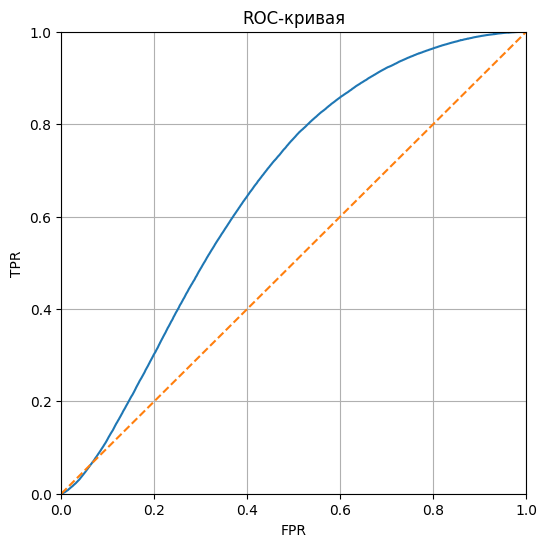

In [27]:
# ROC-кривая
fpr, tpr, thresholds = roc_curve(y_valid, valid_probabilities)

plt.figure(figsize = (6, 6))
plt.step(fpr, tpr, where='post')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.grid(True)
plt.show()

In [28]:
# поиск 5 наиболее подходящих кандидатов для сопоставления
valid_proba_series = pd.Series(valid_probabilities)

valid_candidates = []
for i in range(0, len(valid_proba_series), K_NEIGHBORS):
    query = valid_proba_series[i : i+K_NEIGHBORS]
    index = query.sort_values(ascending=False)[0:N_CELLS].index
    valid_candidates.append(index)

# контроль
print('Кол-во предсказаний:', len(valid_candidates))
print('Кол-во кандидатов:', len(valid_candidates[0]))

Кол-во предсказаний: 100000
Кол-во кандидатов: 5


In [29]:
# оценка качества
acc = 0
for target, candidates in zip(valid_targets.values.tolist(), valid_candidates):
    acc += int(target in valid_base_df.loc[candidates, 'id_candidate'].values)

print('valid_accuracy@{}: {:.2f}%'.format(N_CELLS, acc / len(valid_candidates) * 100))

valid_accuracy@5: 24.07%


### Random Forest

In [ ]:
best_est = 0
best_depth = 0
best_accuracy = 0
list_est = []
list_accurasy = []

for est in tqdm(range(10, 101, 10)):
    for depth in range(1, 13):
        model = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=RANDOM_STATE)
        model.fit(X_train, y_train)
        valid_prediction = model.predict(X_valid)
        valid_accuracy = accuracy_score(y_valid, valid_prediction)
        if valid_accuracy > best_accuracy:
            best_accuracy = valid_accuracy
            best_depth = depth
            best_est = est
    list_est.append(est)
    list_accurasy.append(best_accuracy)

print(f'\n Максимальная оценка модели: {best_accuracy}, при кол-ве деревьев: {best_est}, и их глубине: {best_depth}')


# Визуализация зависимости качества модели от изменения гиперпараметра
accurasy_data = pd.DataFrame({'est': list_est, 'accuracy': list_accurasy})
accurasy_data.plot(style='o-', x='est', y='accuracy', grid=True, legend=False, figsize=(15, 7), ylim=(0.80, 0.81),
                   title='Зависимость качества модели от настройки гиперпараметра.',
                   xlabel='n_estimators - кол-во деревьев в "Случайном лесу"',
                   ylabel='accuracy - доли верных предсказаний')
plt.show()

In [28]:
model = RandomForestClassifier(max_depth=10, n_estimators=40, random_state=RANDOM_STATE)
model.fit(X_train, y_train)
valid_prediction = model.predict(X_valid)
valid_accuracy = accuracy_score(y_valid, valid_prediction)

print(f'\n Максимальная оценка модели: {valid_accuracy}')

MemoryError: Unable to allocate 2.15 GiB for an array with shape (4000000, 144) and data type float32

In [ ]:
# поиск 5 наиболее подходящих кандидатов для сопоставления
valid_proba_series = pd.Series(valid_probabilities)

valid_candidates = []
for i in range(0, len(valid_proba_series), K_NEIGHBORS):
    query = valid_proba_series[i : i+K_NEIGHBORS]
    index = query.sort_values(ascending=False)[0:N_CELLS].index
    valid_candidates.append(index)

# контроль
print('Кол-во предсказаний:', len(valid_candidates))
print('Кол-во кандидатов:', len(valid_candidates[0]))

In [ ]:
# оценка качества
acc = 0
for target, candidates in zip(valid_targets.values.tolist(), valid_candidates):
    acc += int(target in valid_base_df.loc[candidates, 'id_candidate'].values)

print('valid_accuracy@{}: {:.2f}%'.format(N_CELLS, acc / len(valid_candidates) * 100))

## Вывод

Исходные данные имеют хорошее качество. Тип данных - соответствует. Пропуски, дубликаты, выбросы / аномалии - отсутствуют. Разве что, существует "дисбаланс" между значениями. А именно, некоторые значения встречаются особо часто в сравнении со всеми остальными. К примеру: для признака №25 особо популярен значение 813.770071. Оно встречается у ~80% товаров.

Поскольку значения признаков сильно отличаются друг от друга все признаки были отмасштабированы. Это помогло сделать их равнозначными и находить объективные закономерности в дальнейшем.

Было создано и наполнено векторное пространство из объектов датасета `base`. Пространство поделено на 20 кластеров, что ускоряет и уточняет процесс поиска. Для каждого объекта из `train` были найдены 20 ближайших векторов при помощи меры `FlatL2`. Упомянутые числовые параметры были подобраны эмпирическим путём, но отмечу, что опыты с трёхзначными числами не проводились.

По результату поиска ближайших соседей для 61.76% новых товара из `train` найдено 20 кандидатов, среди которах есть целевой (т.е. верно подобранный экспертом).

Далее, среди найденных кандидатов были выделены пятерки самых подходящий. Для этого их применялась Логистическая регрессия. Присутствующий негативный эффект дисбаланса классов был уменьшен с помощью штатного гиперпараметра модели `class_weight`, тем самым назначив разные веса для классов.

Итоговое значение целевой метрики 24.07%.

Это значение не конечное и его можно улучшить уделив время на реализацию некоторых из предложенных ниже вариантов.

**Возможные улучшения:**
1. В поиске ближайших соседей в качестве мера близости использовать [другие варианты](https://github.com/facebookresearch/faiss/wiki/Faiss-indexes), к примеру: `IndexFlatIP` или `IndexIVFPQ`
2. Подобрать другое _кол-во ближайших соседей_ на этапе поиска. Но в обязательном порядке решить проблему _дисбаланса классов_.
3. Установить большее _кол-во кластеров_ для деления векторного пространства.
4. Возможно, стоит избавиться от ряда переменных. Но это может усложнить код в некоторой степени.
5. Возможно, заместо простого объединения векторов (конкатенации), стоит выполнить между ними вычисления и получить новый перечень признаков.
6. Попробовать другие ML-модели, к примеру: `RandomForest` (обычно даёт лучший прогноз, чем _LogisticRegression_) или `CatBoost` (благодаря градиентному спуску, обучается быстрее _RandomForest_).
7. Поскольку объём тренировочной и валидационной выборок одинаков, уместно применить _кросс валидацию_ для обучения. Либо из валидационной выборки выделить тестовую для конечного теста, а валидационную использовать для совершенствования методов обучения.

**P.S.** Я постарался выполнить полностью техническую часть проекта, т.е.: масштабирование данных, поиск ближайших соседей, ранжирование данных, оценка результата предсказаний. Далее дело остаётся за модернизации уже имеющегося процесса, подбор параметров. К сожалению, мне не удалось реализовать это к сроку сдачи проекта, но я планирую закончить проект после. Именно по этому я подробно описал возможности по его улучшению.